# GAIA + APOGEE Dataset - Preliminary Data Exploration

Two labels are better than one

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import random
import math
from astropy.io import fits
from astropy.table import Table
import csv

wave_grid = np.load(os.path.join("data", 'gaia_wavegrid.npy'))

In [2]:
# Import GAIA data
path_gaia = 'data/gaia_observed.h5'

with h5py.File(path_gaia, 'r') as f:
    spectra_gaia = f['spectra train'][:]
    teff_gaia = f['teff train'][:]
    logg_gaia = f['logg train'][:]
    alpha_gaia = f['alpha train'][:]
    feh_gaia = f['feh train'][:]
    ids_gaia = f['source ID train'][:]
    

In [3]:
# Import APOGEE data
path_apogee = '/arc/projects/k-pop/catalogues/sdss-apogee-dr17.fits'
path_idk = '/arc/projects/k-pop/spectra/gaia/rvs/spectra/GAIA_SURVEY_ID_inDR3.fits'


# Open the FITS file
hdulist = fits.open(path_apogee)

# Get all headers information
headers = []
for i, hdu in enumerate(hdulist):
    headers.append(hdu.header)
    
# Access the table data
table = Table(hdulist[1].data)

# Get the TEFF column values
teff_apogee = table['TEFF']
logg_apogee = table['LOGG']
alpha_apogee = table['ALPHA_M']
feh_apogee = table['FE_H']
ids_apogee = table['GAIAEDR3_SOURCE_ID']

# Close the FITS file
hdulist.close()




# https://www.sdss4.org/dr17/irspec/parameters/ recommends FE_H, TEFF, LOGG, ALPHA_M

In [4]:
for header in headers:
    print(header)
    print('\n\n\n\n\n\n\n\n\n\n')

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  VERSION = 'trunk   '           / APOGEE software version APOGEE_VER             END                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [5]:
# Print what percentage of ids_apogee can be found in ids_gaia
overlap = np.count_nonzero(np.isin(ids_apogee, ids_gaia))
overlap_percentage = overlap / len(ids_apogee) * 100
print(f"{overlap_percentage:.2f}% ({overlap:.0f}) of ids_apogee are in ids_gaia")


# From Guiglion 2023: "We cross-matched APOGEE DR17 and Gaia-RVS data based on Gaia EDR3 source_id, leading to a cross-match of 207 953"

# Initialize overlapping data table and name the header rows
overlap_data = [["gaia_id", "teff_gaia", "alpha_gaia", "feh_gaia", "logg_gaia", "teff_apogee", "alpha_apogee", "feh_apogee", "logg_apogee"]]

# Go through each sample, if its ids_apogee is in ids_gaia, add it to the dataset
for i in range(len(ids_apogee)):
    if ids_apogee[i] in ids_gaia:
        gaia_index = np.where(ids_gaia == ids_apogee[i])[0][0]
        overlap_data.append([
            ids_apogee[i],
            teff_gaia[gaia_index],
            alpha_gaia[gaia_index],
            feh_gaia[gaia_index],
            logg_gaia[gaia_index],
            teff_apogee[i],
            alpha_apogee[i],
            feh_apogee[i],
            logg_apogee[i]
        ])

expected_size = len(overlap_data) #Expected size: 96547
print("Expected size: " + str(expected_size))

13.16% (96546) of ids_apogee are in ids_gaia
Expected size: 96547
Data saved to apogee_gaia/overlap_data.csv


In [6]:
# Combine into a single file and save
csv_file = "apogee_gaia/overlap_data.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(overlap_data)

print("Data saved to", csv_file)

Data saved to apogee_gaia/overlap_data.csv


In [7]:
# Load combined file
overlap_data = []
with open(csv_file, mode='r') as file:
    reader = csv.reader(file)
    for row in reader:
        overlap_data.append(row)

# Check expected size 
assert len(overlap_data) == expected_size, "Size of overlap_data (" + str(len(overlap_data)) + ") does not match the expected size of " + str(expected_size)

# If the size matches, the program continues execution
print("Size of overlap_data is " + str(len(overlap_data)) + " as expected")
overlap_data = np.array(overlap_data[1:])

Size of overlap_data is 96547 as expected


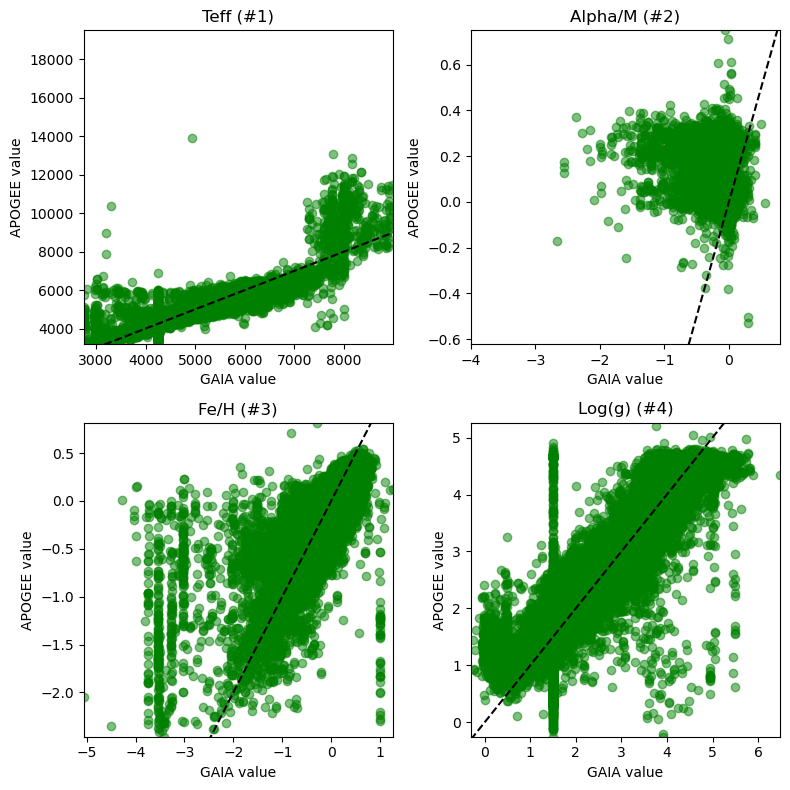

In [15]:
# Plot 4 line graphs in a 2x2 grid

labels = ["Teff", "Alpha/M", "Fe/H", "Log(g)"]

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    # x is column i, y is column i+4
    x = overlap_data[:, i+1].astype(float)  # Column i represents GAIA value
    y = overlap_data[:, i+5].astype(float)  # Column i represents APOGEE value
    
    if (i == 1):
        #multiply 
        x = x * overlap_data[:,3].astype(float)
    
    ax.scatter(x, y, color="green", alpha=0.5)
    ax.plot([min(min(x), min(y)), max(max(x), max(y))], [min(min(x), min(y)), max(max(x), max(y))], 'k--')
    ax.set_title(labels[i] + " (#" + str(i+1) + ")")
    ax.set_ylabel("APOGEE value")
    ax.set_xlabel("GAIA value")
    ax.set_ylim([min(y), max(y)])
    ax.set_xlim([min(x), max(x)])

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()